# About Notebook

It is basic starter notebook for Stable-Diffusion Image-to-Prompt, written in `keras`, and `transformer` from huggingface. It contains both **training code** and **inference code**. Please note, the training code is configured on **TPU-VM**, otherwise on **GPU**.


In [1]:
# set True for 'Inference' on GPU (turn off the internet)
# set False for 'Training' on TPU-VM (turn on the internet)
SUBMIT = False

In [2]:
import os
import warnings
import logging
from IPython.display import clear_output
warnings.filterwarnings('ignore')
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
logging.disable(logging.WARNING)

!pip install -U -q scikit-learn
!pip install -U -q transformers
clear_output()

In [6]:
import os
import glob
import warnings
import random
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import callbacks
from tensorflow.keras.optimizers import schedules
from tensorflow.python.client import device_lib

import transformers
from transformers import AutoConfig
from transformers import TFBertTokenizer
from transformers import TFAutoModel
from transformers import ViTFeatureExtractor
from transformers import TFViTModel

transformers.logging.disable_progress_bar()
clear_output()

# Devices

In [4]:
if SUBMIT:
    physical_devices = tf.config.list_physical_devices('GPU')
    tf.config.optimizer.set_jit(True)
    keras.mixed_precision.set_global_policy("mixed_float16")
    [tf.config.experimental.set_memory_growth(pd, True) for pd in physical_devices]
    strategy = tf.distribute.MirroredStrategy()
else:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect(tpu="local")
    strategy = tf.distribute.TPUStrategy(tpu)
    keras.mixed_precision.set_global_policy("mixed_bfloat16")

    
seed = 42
input_size = 224
batch_size = 32 * strategy.num_replicas_in_sync
num_epochs = 10
keras.utils.set_random_seed(seed)
tf.__version__, transformers.__version__

('2.12.0', '4.31.0')

# Data [Training]

In [17]:
df = pd.read_csv('/kaggle/input/dbfussion/diffusiondb.csv')
trn_df, val_df = train_test_split(
    df, test_size=0.1, random_state=seed
)
display(df.sample())
trn_df.shape, val_df.shape

,filepath,prompt
45724,/kaggle/input/diffusiondb-2m-part-0401-to-0500...,matrioska eating candies old style


((138888, 2), (15432, 2))

In [18]:
# get max sequence
trn_df["prompt"].apply(lambda x: len(str(x).split())).describe() # 138888

count    138888.000000
mean         13.130083
std          10.864133
min           5.000000
25%           7.000000
50%          10.000000
75%          15.000000
max         480.000000
Name: prompt, dtype: float64

# Dataloader [Training]

In [19]:
model_id = 'sentence-transformers/all-MiniLM-L6-v2'
tokenizer = TFBertTokenizer.from_pretrained(model_id)

def read_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.io.decode_png(image, 3)
    image = tf.image.resize(image, (input_size, input_size))
    return image

def batch_tokenize(prompt):
    tokenized = tokenizer(
        prompt, 
        padding="max_length", 
        truncation=True, 
        max_length=512
    )
    return tokenized

In [20]:
def dataloader(
    image_paths, 
    prompts, 
    shuffle=True, 
    repeat=True, 
    batch_size=1,
):
    dataset = tf.data.Dataset.from_tensor_slices(
        (image_paths, prompts)
    )
    dataset = dataset.map(
        lambda x, y: (read_image(x), y),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    dataset = dataset.batch(
        batch_size, drop_remainder=True
    )
    dataset = dataset.map(
        lambda x, y: (x, (batch_tokenize(y))),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    
    if shuffle:
        dataset = dataset.shuffle(
            batch_size * 8, reshuffle_each_iteration = False
        )
    
    if repeat:
        dataset = dataset.repeat()
        
    return dataset.prefetch(tf.data.AUTOTUNE)

In [21]:
train_ds = dataloader(
    trn_df["filepath"].values, 
    trn_df['prompt'].values, 
    shuffle=True, 
    repeat=False,
    batch_size=batch_size
)

valid_ds = dataloader(
    val_df["filepath"].values, 
    val_df['prompt'].values, 
    shuffle=False, 
    repeat=False, 
    batch_size=batch_size
)

# Model

In [22]:
def preprocess(x):
    x = keras.layers.Rescaling(scale=1./127.5, offset=-1.0)(x)
    x = keras.layers.Permute(dims=(3, 1, 2))(x)
    return x
    
def augment(x):
    pipeline = keras.Sequential(
        [
            layers.RandomFlip("horizontal")
        ]
    )
    return pipeline(x)

In [23]:
def get_model(mode='inference'):
    input = keras.Input(shape=(input_size, input_size, 3))
    x = augment(input)
    x = preprocess(x)

    # vit model
    if mode=='inference':
        config =  AutoConfig.from_pretrained(
            '/kaggle/input/cmp-stablediffusion-imgtopt', 
            local_files_only=True
        )
        hf_model = TFViTModel.from_config(config)
        x = hf_model(x)
    else:
        x = TFViTModel.from_pretrained(
            'google/vit-base-patch16-224'
        )(x)
    x = keras.layers.Lambda(lambda v: v[:, 0])(x.last_hidden_state)
    
    # output
    output = keras.layers.Dense(
        384, activation=None, dtype=tf.float32
    )(x)

    model = keras.Model(input, output)
    return model

**Sentence Transformer (all-MiniLM-L6-v2)**

It will be run on inside the model.

In [24]:
# ref. https://www.philschmid.de/tensorflow-sentence-transformers
class TFSentenceTransformer(keras.layers.Layer):
    def __init__(self,  model_id, **kwargs):
        super().__init__(**kwargs)
        self.st_model = TFAutoModel.from_pretrained(model_id, **kwargs)

    def call(self, inputs, normalize=True):
        model_output = self.st_model(inputs)
        embeddings = self.mean_pooling(
            model_output, inputs["attention_mask"]
        )
        if normalize:
            embeddings = self.normalize(embeddings)
        return embeddings

    def mean_pooling(self, model_output, attention_mask):
        token_embeddings = model_output[0]
        input_mask_expanded = tf.cast(
            tf.broadcast_to(
                tf.expand_dims(attention_mask, -1), 
                tf.shape(token_embeddings)
            ),
            token_embeddings.dtype
        )
        token_mask = tf.reduce_sum(
            token_embeddings * input_mask_expanded, axis=1
        )
        mask_clip = tf.clip_by_value(
            tf.reduce_sum(input_mask_expanded, axis=1), 
            1e-9, 
            tf.float32.max
        )
        return token_mask / mask_clip
        
    def normalize(self, embeddings):
        embeddings, _ = tf.linalg.normalize(
            embeddings, 2, axis=1
        )
        return embeddings

In [25]:
class TextTokenToEmbedding(keras.Model):
    '''Transform the text/prompt-token gt to 384-D embedding with sentence transformer.
    '''
    def __init__(self, model, **kwargs):
        super().__init__(**kwargs)
        self.model = model 
    
    def call(self, inputs):
        return self.model(inputs)
    
    def train_step(self, data):
        x, y = data
        y = tfst_model(y, normalize=False)
        return super().train_step((x, y))
    
    def test_step(self, data):
        x, y = data
        y = tfst_model(y, normalize=False)
        return super().test_step((x, y))
    
    # kaggle.com/code/ipythonx/keras-rsna-breast-cancer-detection
    def save_weights(
        self, filepath, overwrite=True, save_format=None, options=None
    ):
        # Overriding this method will allow us to use the `ModelCheckpoint`
        self.model.save_weights(
            filepath=filepath,
            overwrite=overwrite,
            save_format=save_format,
            options=options,
        )
        
    def save(
        self, filepath, overwrite=True, include_optimizer=True, 
        save_format=None, signatures=None, options=None
    ):
        # Overriding this method will allow us to use the `ModelCheckpoint`
        self.model.save(
            filepath=filepath,
            overwrite=overwrite,
            save_format=save_format,
            options=options,
            include_optimizer=include_optimizer,
            signatures=signatures
        )

In [26]:
# https://stackoverflow.com/a/44933346/9215780
cosine_similarity_loss = keras.losses.CosineSimilarity(
    reduction='none'
)

def CosineEmbeddingLoss(margin=0., target=1):
    def cosine_embedding_loss_fn(input_one, input_two):
        similarity = - cosine_similarity_loss(input_one, input_two)
        return tf.reduce_mean(
            tf.where(
                tf.equal(target, 1),
                1. - similarity,
                tf.maximum(
                    tf.zeros_like(similarity), similarity - margin
                )
            )
        )
    return cosine_embedding_loss_fn

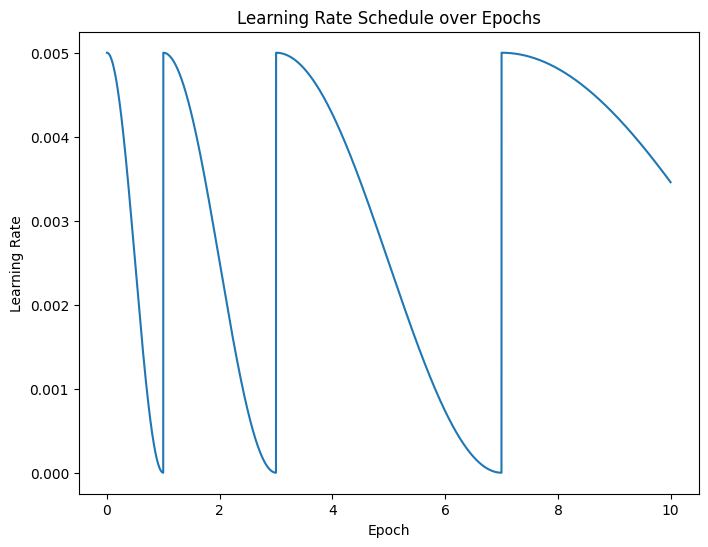

In [44]:
with strategy.scope():
    warmup_fraction = 0.10  # 10% of total epochs for warmup
    num_warmup_epochs = int(num_epochs * warmup_fraction)
    initial_learning_rate = 0.01 * batch_size / 512
    first_decay_steps = num_warmup_epochs * len(trn_df) // batch_size
    lr_schedule = schedules.CosineDecayRestarts(
        initial_learning_rate=initial_learning_rate,
        first_decay_steps=first_decay_steps,
        t_mul=2.0,
        m_mul=1.0,
        alpha=0.0
    )
    optim = keras.optimizers.SGD(
        learning_rate=lr_schedule, 
        momentum=0.9
    )
    
steps_per_epoch = len(trn_df) // batch_size
steps = np.arange(num_epochs * steps_per_epoch)
lr = lr_schedule(steps)
# Plot learning rate schedule
plt.figure(figsize=(8, 6))
plt.plot(steps / steps_per_epoch, lr)
plt.title("Learning Rate Schedule over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.show()

In [45]:
with strategy.scope():
    if SUBMIT:
        model = get_model(mode='inference')
        model.load_weights(
            '/kaggle/input/cmp-stablediffusion-imgtopt/model.02-0.533.h5'
        )
        model.compile(jit_compile=True)
        model.trainable = False
    else:
        # token to text-embedding
        tfst_model = TFSentenceTransformer(model_id)
        tfst_model.trainable = False

        model = get_model(mode='training')
        model = TextTokenToEmbedding(model)
        model.compile(
            optimizer=optim,
            loss=CosineEmbeddingLoss(margin=0., target=1),
            metrics=[
                metrics.CosineSimilarity(name='cos')
            ],
        )
        model.build(
            input_shape=(None, input_size, input_size, 3)
        )
    
clear_output()

In [46]:
model.summary(
    expand_nested=True, 
    line_length=100, 
    show_trainable=True
)

Model: "text_token_to_embedding_1"
_______________________________________________________________________________________________________________
 Layer (type)                                Output Shape                            Param #        Trainable  
 model_1 (Functional)                        (None, 384)                             86684544       Y          
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| input_2 (InputLayer)                      [(None, 224, 224, 3)]                   0              Y          |
|                                                                                                             |
| sequential_1 (Sequential)                 (None, 224, 224, 3)                     0              Y          |
||¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯||
|| random_flip_1 (RandomFlip)              (None, 224, 224, 3)       

In [47]:
if SUBMIT:
    training_log = pd.read_csv('/kaggle/input/cmp-stablediffusion-imgtopt/training_log.csv')
    display(training_log.head())
else:
    model.fit(
        train_ds, 
        validation_data=valid_ds, 
        epochs=num_epochs,
        callbacks=[
            callbacks.ModelCheckpoint(
                filepath='model.{epoch:02d}-{val_cos:.3f}.h5',
                monitor='val_cos',
                mode='max',
                save_best_only=True
            ),
            callbacks.CSVLogger('training_log.csv')
        ]
    )

Epoch 1/10
542/542 [==============================] - 278s 300ms/step - loss: 0.6915 - cos: 0.3085 - val_loss: 0.6352 - val_cos: 0.3648
Epoch 2/10
542/542 [==============================] - 167s 258ms/step - loss: 0.6283 - cos: 0.3717 - val_loss: 0.6274 - val_cos: 0.3726
Epoch 3/10
542/542 [==============================] - 173s 268ms/step - loss: 0.6249 - cos: 0.3751 - val_loss: 0.6264 - val_cos: 0.3736
Epoch 4/10
542/542 [==============================] - 169s 262ms/step - loss: 0.6215 - cos: 0.3785 - val_loss: 0.6198 - val_cos: 0.3802
Epoch 5/10
542/542 [==============================] - 168s 258ms/step - loss: 0.6145 - cos: 0.3855 - val_loss: 0.6135 - val_cos: 0.3865
Epoch 6/10
542/542 [==============================] - 167s 257ms/step - loss: 0.6097 - cos: 0.3903 - val_loss: 0.6107 - val_cos: 0.3893
Epoch 7/10
542/542 [==============================] - 167s 258ms/step - loss: 0.6082 - cos: 0.3918 - val_loss: 0.6102 - val_cos: 0.3898
Epoch 8/10
542/542 [============================

# Data [Inference]

In [48]:
comp_path = '/kaggle/input/stable-diffusion-image-to-prompts'
imag_path = glob.glob(f'{comp_path}/images/*.png')
images = os.listdir(os.path.join(comp_path, 'images'))
imgIds = [i.split('.')[0] for i in images]

EMBEDDING_LENGTH = 384
eIds = list(range(EMBEDDING_LENGTH))

imgId_eId = [
    '_'.join(map(str, i)) for i in zip(
        np.repeat(imgIds, EMBEDDING_LENGTH),
        np.tile(range(EMBEDDING_LENGTH), len(imgIds)))
]

# Dataloader [Inference]

In [49]:
def dataloader(
    image_paths, batch_size=1
):
    dataset = tf.data.Dataset.from_tensor_slices(
        (image_paths)
    )
    dataset = dataset.map(read_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size, drop_remainder=False)
    return dataset.prefetch(tf.data.AUTOTUNE)

In [50]:
test_ds = dataloader(
    imag_path, batch_size=batch_size
)

# Prediction

In [51]:
prompt_embeddings = model.predict(test_ds)
prompt_embeddings = np.vstack(prompt_embeddings).flatten()

1/1 [==============================] - 13s 13s/step


In [52]:
submission = pd.DataFrame(
    index=imgId_eId,
    data=prompt_embeddings,
    columns=['val']
).rename_axis('imgId_eId')
submission.to_csv('submission.csv')
submission.head()

,val
imgId_eId,
f27825b2c_0,-1.558183
f27825b2c_1,2.309568
f27825b2c_2,-0.488316
f27825b2c_3,-0.240991
f27825b2c_4,-0.735084
